In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as ss 

# our script
import gp_bandpowers as gpb

# setting for matplotlib
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

%matplotlib inline

### Load Training Set

In [2]:
data = pd.read_csv('training_points/bandpowers_1000.csv').iloc[:,1:]

### Data Description

The first 8 columns correspond to the 6 cosmological and 2 systematic parameters and are in the following order:

$$
\left[\Omega_{\textrm{cdm}}h^{2},\,\Omega_{\textrm{b}}h^{2},\,\textrm{ln}\left(10^{10}A_{\textrm{s}}\right),\,n_{\textrm{s}},\,h,\,A_{\textrm{bary}},\,\Sigma m_{\nu},\,A_{\textrm{IA}}\right]
$$

<img src="images/input_parameters.png" style="height:250px" class="center">
and the remaining 24 columns are the band powers. Therefore, we can build a GP which maps the 8 parameters to either one of the 24 band powers and we show one example below. 

### Build GP

In [3]:
# the noise level (jitter term) for the GP is in log 
sigma      = [-40.0] 
bandIndex  = 1 # between 0 and 23 inclusive
inputData  = np.array(data)[:,[0,1,2,3,4,5,6,7,bandIndex+8]]

In [4]:
ndim   = 8

# Set some bounds on the kernel hyperparameters, 
# effectively a prior as we would have done with a full Bayesian analysis
bnd    = np.repeat(np.array([[-1.5,6]]), ndim+1, axis = 0)
bnd[0] = np.array([0, 2])

### Train GP

In [5]:
gp     = gpb.GP(inputData, sigma=sigma, train = True, nrestart = 2, ndim = ndim)
gp.transform()
gp.fit(method = 'L-BFGS-B', bounds = bnd, options = {'ftol':1E-12, 'maxiter':500})

Performing Optimization step 1
Performing Optimization step 2


<div style="text-align: justify">The first output is the negative log-marginal likelihood of the GP. Normally we expect local optima. We can repeat the optimisation by changing nrestart. The second output is a vector with all the kernel hyperparameters (in log): amplitude and 8 lengthscales.</div>

### Prediction

In [6]:
# input parameters 
point = np.array([0.1295,  0.0224,  2.895 ,  0.9948,  0.7411,  1.0078,  0.5692, -1.9163])

# exact band powers(after running CLASS) - this is in matrix logarithm
truth = np.array([-14.2674, -13.6626, -13.3472, -13.0325,   1.3146,   1.182,    1.2528,   1.2598,
 -14.4343, -13.8934, -13.5505, -13.2225,   1.6632,   1.7638,   1.7675,   1.7708,
   1.3421,   1.4618,   1.4726,   1.4902, -13.288,  -12.9761, -12.6294, -12.2721])

# compute prediction using GP 
mean_     = gp.sampleBandPower(point, mean = True)
samples   = gp.sampleBandPower(point, mean = False, nsamples = 5000)

### Plotting

In [7]:
std  = np.std(samples)
dist = ss.norm(mean_, std)
x = np.linspace(mean_ - 5*std, mean_ + 5*std, 2000)
y = dist.pdf(x)

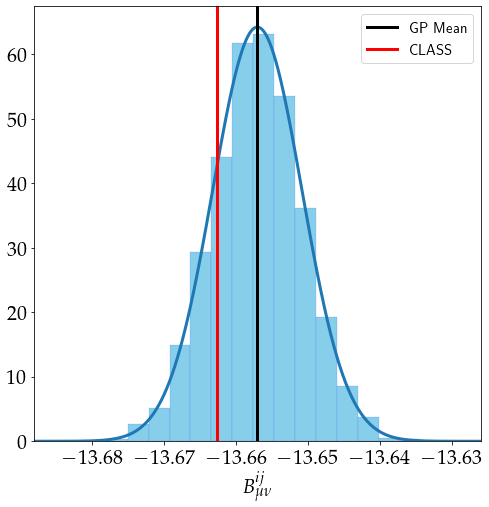

In [8]:
plt.figure(figsize = (8,8))
plt.plot(x,y, lw = 3)
plt.xlim(min(x), max(x))
plt.hist(samples, density = True, color = 'skyblue', bins = 15, edgecolor='blue', linewidth=0.1)
plt.axvline(mean_, color = 'k', lw = 3, label = 'GP Mean')
plt.axvline(truth[bandIndex], color = 'r', lw = 3, label = 'CLASS')
plt.xlabel(r'$B^{ij}_{\mu\nu}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'size':15})
plt.show()